In [29]:
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from scipy.spatial.transform import Rotation as R

import math
from copy import copy
import glob
import random
from scipy.stats import kendalltau

from scipy.optimize import linear_sum_assignment

In [6]:
flist = sorted(glob.glob('../../demos/perms/order*'))
random.shuffle(flist)

In [7]:
# Load 300 examples
obj_list = []
im_list = []
for i,f in enumerate(flist[0:300]):
    run = int(f.split('_')[1][:-4])

    im = np.load('../../demos/perms/ims_%04d.npy'%run)
    obj_ids = np.load('../../demos/perms/order_%04d.npy'%run)
    
    obj_list.append(obj_ids)
    im_list.append(im)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm
device = torch.device('cuda:1')

In [10]:
# Set up pytorch dataloader
class Sampler(Dataset):
    
    def __init__(self, ims, actions):
        
        self.ims = torch.FloatTensor(ims.astype('float')).to(device)
        self.actions = torch.LongTensor(actions.astype('int')).to(device)
        
        
    def __len__(self):
        
        return self.ims.shape[0]
    
    def __getitem__(self, index):
        
        im = self.ims[index,:,:,:]
        actions = self.actions[index,:]
        return im, actions


In [11]:
dataset = Sampler(np.swapaxes(np.stack(im_list),1,3),np.stack(obj_list))

train_dataset,test_dataset = torch.utils.data.random_split(dataset, [100,len(im_list)-100])

In [12]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [22]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class TCNNet(nn.Module):

    def __init__(self, latent_dim=16, image_channels=3, K=6):
        super(TCNNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            Flatten(),
            nn.Linear(4096, latent_dim*K),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        
        self.tcn = TemporalConvNet(K,[K]*K)
        
        # Sinkhorn params
        self.latent_dim = latent_dim
        self.K = K
        
        self.criterion = nn.CrossEntropyLoss()

        self.fc = nn.Sequential(
                         nn.Linear(latent_dim, K))
    
    def forward(self, im):
        
        latent = self.encoder(im)
        stacked_latent = torch.reshape(latent,(-1,self.K,self.latent_dim))
        
        tc = self.tcn(stacked_latent)
        
        y = self.fc(tc)
        logits = torch.nn.functional.softmax(y,dim=-1)
        return logits
    
    def loss(self, seq, im):
        
        seq_logits = self.forward(im)

        return self.criterion(seq_logits.view(-1,self.K),seq.view(-1)), seq_logits

In [23]:
bc = TCNNet(latent_dim=128, image_channels=3, K=6)
bc.to(device)
optimizer = torch.optim.Adam(bc.parameters(), lr=3e-4)

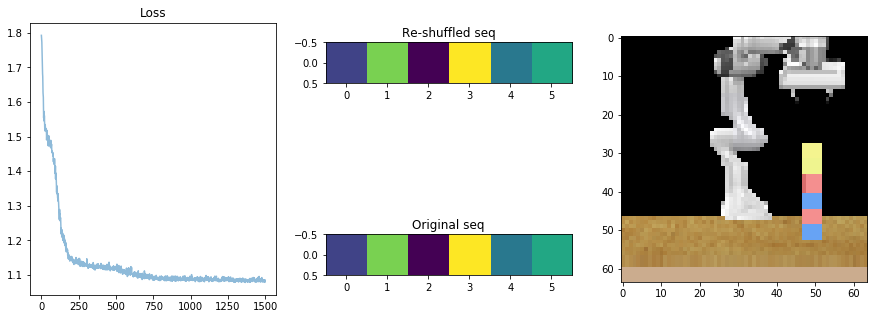

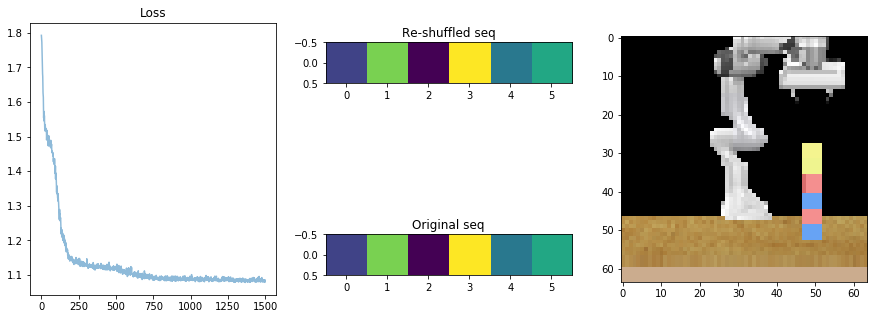

In [24]:
plt.figure(figsize=(15,5))

n_epochs = 1500
losses = []

for j in range(n_epochs):
    
    batch_losses = []
    for im, seq in train_loader:
    
        loss, seq_pred = bc.loss(seq, im)
        
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    
    plt.clf()
    plt.cla()
    plt.subplot(1,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Loss')

    
    plt.subplot(3,3,2)
    seq_p = np.argmax(seq_pred[0,:,:].cpu().detach().numpy(),-1)
    plt.imshow(seq_p.reshape(1,-1))
    plt.title('Re-shuffled seq')
    
    plt.subplot(3,3,8)
    plt.imshow(seq[0,:].cpu().detach().numpy().reshape(1,-1))
    plt.title('Original seq')
    
    plt.subplot(1,3,3)
    plt.imshow(np.swapaxes(im[0,:,:,:].cpu().detach().numpy(),0,2))
    
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [25]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
bc.eval()

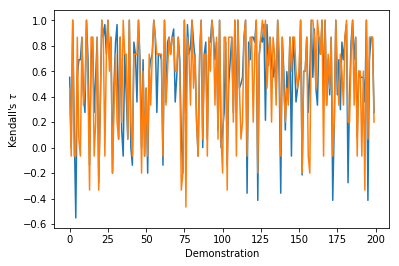

In [30]:
tau_list = []
for im,seq in test_loader:
    seq_pred = bc(im)
    obj_ids = np.argmax(seq_pred[0,:,:].cpu().detach().numpy(),-1)
    tau, _ = kendalltau(obj_ids, seq[0,:].cpu().numpy())
    tau_list.append(tau)

tau_list_hung = []
for im,seq in test_loader:
    seq_pred = bc(im)
    _,obj_ids = linear_sum_assignment(1.0-seq_pred[0,:,:].cpu().detach().numpy())
    tau, _ = kendalltau(obj_ids, seq[0,:].cpu().numpy())
    tau_list_hung.append(tau)

plt.plot(tau_list)
plt.plot(tau_list_hung)
plt.ylabel('Kendall\'s $\\tau$')
plt.xlabel('Demonstration')
plt.show()

In [31]:
from pyrep import PyRep
from pyrep.robots.arms.panda import Panda
from pyrep.robots.end_effectors.panda_gripper import PandaGripper
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape

from scipy.spatial.transform import Rotation as R

import math
from copy import copy

In [34]:
pr = PyRep()
pr.launch('../../assets/scene_panda.ttt', headless=False)

In [35]:
agent = Panda()
gripper = PandaGripper()

In [36]:
home_pos = agent.get_tip().get_position()
home_orient = agent.get_tip().get_orientation()

In [37]:
def grasp(grip=False):
    if grip:
        pos = 0.1
    else:
        pos = 0.9
    actuated = False
    ims = []
    states = []
    while not actuated:
        actuated = gripper.actuate(pos,0.1)
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [38]:
def move_above_object(object_name='',offset=0.05):
    pos = agent.get_object(object_name).get_position()
    pos[2] = pos[2] + offset
    orient = [-np.pi,0,np.pi/2]

    path = agent.get_path(position=pos,euler=orient)

    done = False
    ims = []
    states = []
    while not done:
        done = path.step()
        im0,im1 = get_image()
        ims.append((im0,im1))
        states.append(agent.get_tip().get_pose())
    return ims,states

In [39]:
def get_image():
    cam = agent.get_object('Vision_sensor_front')
    im0 = cam.capture_rgb()
    cam1 = agent.get_object('Vision_sensor')
    im1 = cam1.capture_rgb()
    pr.step()
    return im0, im1

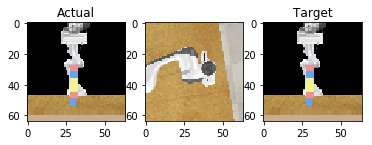

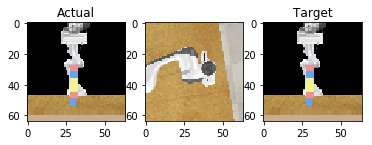

In [47]:
# Set up a dataloader for testing
tl = iter(train_loader)

# Run this repeatedly to see how the action sequencing works for different images
im,seq = next(tl)
seq_pred = bc(im)
_,obj_ids = linear_sum_assignment(1.0-seq_pred[0,:,:].cpu().detach().numpy())

pr.start()

grasp(grip=False)
gripper.release()
ims = []
states = []
for j in range(1,len(obj_ids)):
    object_name = 'Cuboid%d'%obj_ids[j]
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=True)
    ims = ims + i
    states = states + s
    gripper.grasp(agent.get_object(object_name))
    i,s = move_above_object(object_name,offset=0.08)
    ims = ims + i
    states = states + s
    object_name = 'Cuboid%d'%obj_ids[j-1]
    i,s = move_above_object(object_name,offset=0.15)
    ims = ims + i
    states = states + s
    i,s = move_above_object(object_name,offset=0.05)
    ims = ims + i
    states = states + s
    i,s = grasp(grip=False)
    ims = ims + i
    states = states + s
    gripper.release()
    i,s = move_above_object(object_name,offset=0.2)
    ims = ims + i
    states = states + s
    #clear_view()
    
    plt.cla()
    plt.clf()
    plt.subplot(1,3,1)
    plt.imshow(ims[-1][0])
    plt.title('Actual')
    plt.subplot(1,3,2)
    plt.imshow(ims[-1][1])
    plt.subplot(1,3,3)
    plt.imshow(np.swapaxes(im.cpu().numpy()[0,:,:],2,0))
    plt.title('Target')
    display.clear_output(wait=True)
    display.display(plt.gcf())

pr.stop()

In [ ]:
pr.shutdown()